In [10]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'jshtml'
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import random
import time
random.seed(12345)

In [11]:
class Food(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.is_marked = False

In [12]:
class Bin(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

In [13]:
# Collector & Explorer
class Waiter(Agent):
    def __init__(self, unique_id, model, x_range):
        super().__init__(unique_id, model)
        self.x_range = x_range
        self.carrying_food = False

    def move(self):
        if self.model.bin_position == None and self.carrying_food == False:
            self.search_bin()
        elif self.model.bin_position != None and self.carrying_food == False:
            self.search_food()
        elif self.carrying_food == False and self.model.marked_food == self.model.total_food:
            self.search_food_freely()
        elif self.carrying_food == True:
            self.move_to_bin()

    def search_bin(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        possible_steps = [x for x in possible_steps if x[0] in range(self.x_range[0], self.x_range[1])]
        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(agent, Bin):  # Suponiendo que Bin es una clase para los agentes contenedor
                self.model.bin_position = self.pos
                return
            elif isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food += 1

        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    def pick_food(self, agent):
        self.model.grid._remove_agent(self.pos, agent)
        self.model.schedule.remove(agent)
        self.model.matrix[self.pos[0]][self.pos[1]] = 0
        
    def search_food(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        possible_steps = [x for x in possible_steps if x[0] not in range(self.x_range[0], self.x_range[1])]
        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food += 1
                    self.carrying_food = True
                    self.pick_food(agent)

        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def search_food_freely(self):
        # Go to closest marked food

    def step(self):
        self.move()

In [14]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for (cell_content, (x, y)) in model.grid.coord_iter():
        for content in cell_content:
            if isinstance(content, Bin):
                grid[y][x] = 3
            elif isinstance(content, Food):
                grid[y][x] = 1
            elif isinstance(content, Waiter):
                grid[y][x] = 2
    return grid

In [15]:
class Restaurant(Model):
    random.seed(12345)
    def __init__(self, width, height, num_waiters, num_foods):
        self.num_waiters = num_waiters
        self.num_foods = num_foods
        self.total_food = num_foods
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, False)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        self.matrix = np.zeros((width, height))
        self.food_id = 0
        self.last_food_creation_time = time.time()
        self.column_width = None
        self.bin_position = 0
        self.marked_food = set()

        self.create_waiters()
        self.create_bin()

    def random_position(self):
        x = random.randrange(self.grid.width)
        y = random.randrange(self.grid.height)
        return (x, y)

    def create_bin(self):
        bin_id = "bin"
        x, y = self.random_position()
        bin = Bin(bin_id, self)
        self.schedule.add(bin)
        self.grid.place_agent(bin, (x, y))

    def create_foods(self):
        food_unit = random.randint(2, 5)

        if food_unit > self.num_foods:
            food_unit = self.num_foods

        for i in range(food_unit):
            food_id = "food-" + str(self.food_id)
            while True:
                x, y = self.random_position()
                if self.grid.is_cell_empty((x, y)):
                    food = Food(food_id, self)
                    self.schedule.add(food)
                    self.grid.place_agent(food, (x, y))
                    self.food_id += 1
                    break
        self.num_foods -= food_unit

    def create_waiters(self):
        self.column_width =  self.grid.width // self.num_waiters
        column = 0
        for i in range(self.num_waiters):
            waiter_id = "waiter-" + str(i)
            while True:
                x = self.random.randrange(column, column + self.column_width - 1)
                x_range = (column, column + self.column_width - 1)
                y = self.random.randrange(self.grid.height)
                if self.grid.is_cell_empty((x, y)):
                    waiter = Waiter(waiter_id, self, x_range)
                    self.schedule.add(waiter)
                    self.grid.place_agent(waiter, (x, y))
                    break
            column += self.column_width

    def step(self):
        start_time = time.time()

        current_time = time.time()
        if current_time - self.last_food_creation_time >= .05:
            self.create_foods()
            self.last_food_creation_time = current_time
        self.datacollector.collect(self)
        self.schedule.step()

        end_time = time.time()
        step_duration = end_time - start_time

        if step_duration < 0.001:
            time.sleep(0.001 - step_duration)

In [16]:
# CONSTANTS
WIDTH = 20
HEIGHT = 20
NUM_WAITERS = 5
NUM_FOODS = 47

In [17]:
model = Restaurant(WIDTH, HEIGHT, NUM_WAITERS, NUM_FOODS)
for i in range(1500):
    model.step()
data = model.datacollector.get_model_vars_dataframe()

C:\Users\santi\AppData\Local\Temp\ipykernel_2700\3943806308.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(data.iloc[0][0], cmap="Blues")
C:\Users\santi\AppData\Local\Temp\ipykernel_2700\3943806308.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[i][0])


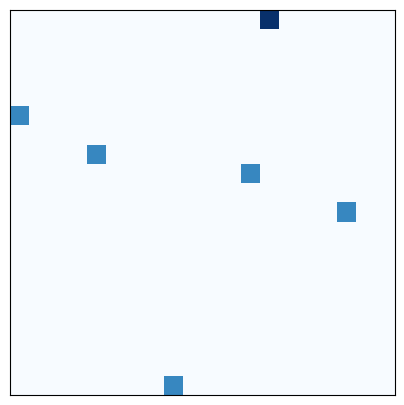

In [18]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(data.iloc[0][0], cmap="Blues")

def animate(i):
    patch.set_data(data.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=1500, interval=1)

anim